# Min distance objective

In [99]:
# import Pkg
# Pkg.add("Mosek")
# Pkg.build("Mosek")

In [100]:
# Pkg.add("KNITRO")
# Pkg.build("KNITRO")

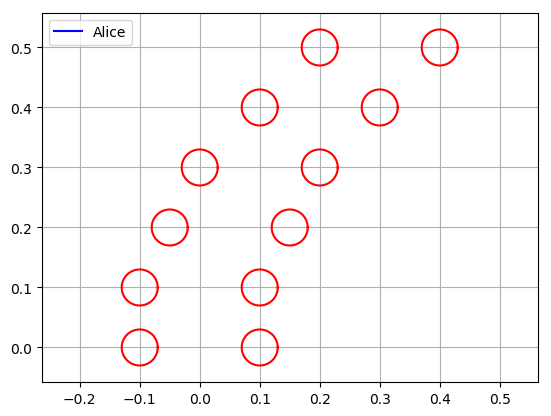

Infeasible
d_tot_actual: 0
Total energy: 0
Meeting location: (NaN, NaN)


┌ Warning: Not solved to optimality, status: Infeasible
└ @ JuMP /Users/alexpletta/.julia/packages/JuMP/PbnIJ/src/nlp.jl:1283
┌ Warning: Variable value not defined for component of x_A. Check that the model was properly solved.
└ @ JuMP /Users/alexpletta/.julia/packages/JuMP/PbnIJ/src/JuMP.jl:475


In [38]:
using JuMP, PyPlot, Ipopt

# Define model, variables, constraints, objective
m = Model(solver=IpoptSolver(print_level=0))

time = 3
start = [0, 0]
finish = [0, 0.4]
#time_step = 36
circles = [-0.1 0;
            0.1 0;
            -0.1 0.1;
            0.1 0.1
            0.15 0.2;
            -0.05 0.2;
            0.2 0.3;
            0 0.3;
            0.3 0.4;
            0.1 0.4;
            0.4 0.5;
            0.2 0.5]

r = 0.03

num_circles, dim = size(circles)

@variable(m, x_A[1:2, 1:time])
@variable(m, v_A[1:2, 1:time])
@variable(m, u_A[1:2, 1:time])

# x index on east/west, y index on north/south
@constraint(m, x_A[:, 1] .== start) # Alice's initial position
@constraint(m, v_A[:, 1] .== [0, 0]) # Alice's initial velocity 

# Keep path away from obstacles defined by radii from circle center
for t in 1:time
    for c in 1:num_circles
    @NLconstraint(m, sqrt( (x_A[1,t]-circles[c,1])^2 + (x_A[2,t]-circles[c,2])^2 ) >= r + 0.01) 
    end
end

# Dynamic equations
for t in 1:time-1
    @constraint(m, x_A[:, t+1] .== x_A[:, t] + (1/3600)*v_A[:, t]) # Alice's position    
    @constraint(m, v_A[:, t+1] .== v_A[:, t] + u_A[:, t]) # Alice's velocity
end

@constraint(m, x_A[:, time] .== finish) # final location
@constraint(m, v_A[:, time] .== [0,0]) # final velocity

# Adds up euclidian distance between each time step
d_tot = @NLexpression(m, sum{ (x_A[1,t+1]-x_A[1,t])^2 + (x_A[2,t+1]-x_A[2,t])^2, t=1:time-1} )  

#@NLobjective(m, Min, d_tot)
@objective(m, Min, sum(u_A.^2)) # minimize total energy

# Solve
status = solve(m)
println(status)

d_tot_actual = 0
# for t in 1:time-1
#    d_tot_actual += sqrt( (getvalue(x_A[1,t+1])-getvalue(x_A[1,t]))^2 + (getvalue(x_A[2,t+1])-getvalue(x_A[2,t]))^2) 
# end

#println("d_tot: ", getvalue(d_tot))
println("d_tot_actual: ", d_tot_actual)

# Printing all values for d_tot
# for t in 1:time-1
#     println(t," ",sqrt( (getvalue(x_A[1,t+1])-getvalue(x_A[1,t]))^2 + (getvalue(x_A[2,t+1])-getvalue(x_A[2,t]))^2 ))
# end

# Output
x_A = getvalue(x_A)
println("Total energy: ", getobjectivevalue(m))
println("Meeting location: (", x_A[1,time],", ",x_A[2,time],")")

# Graph path
plot(x_A[1, :], x_A[2, :], color="blue", label="Alice")
#plot(x_A[1, time_step], x_A[2, time_step], ".", color="orange")

# Plot circle
t = range(0,stop=2pi,length=100)         # parameter that traverses the circle
for c in 1:num_circles
    plot( circles[c,1] .+ r*cos.(t), circles[c,2] .+ r*sin.(t), color="red")  # plot circle radius r with center (x1, x2)
end

# Plot time steps
for t in 1:time
   plot(x_A[1, t], x_A[2, t], ".", color="orange")
end

# Formatting
axis("equal")                            # make x and y scales equal
grid("on")
legend()
;

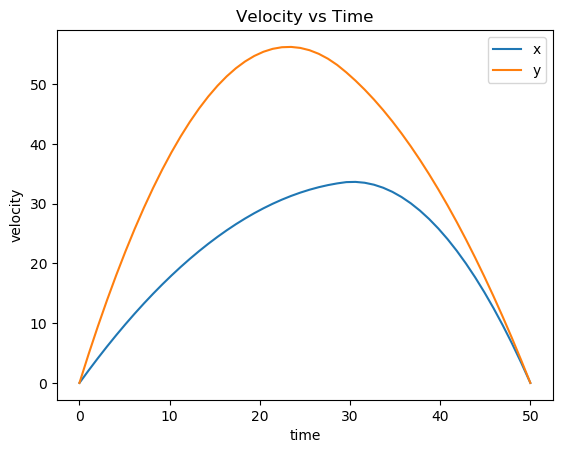

In [33]:
# Velocity plot
x = range(0, stop=time, length=time)
plot(x[:], getvalue(v_A)[1,:], label="x" )
plot(x[:], getvalue(v_A)[2,:], label="y" )
title("Velocity vs Time")
xlabel("time")
ylabel("velocity")
legend()
;

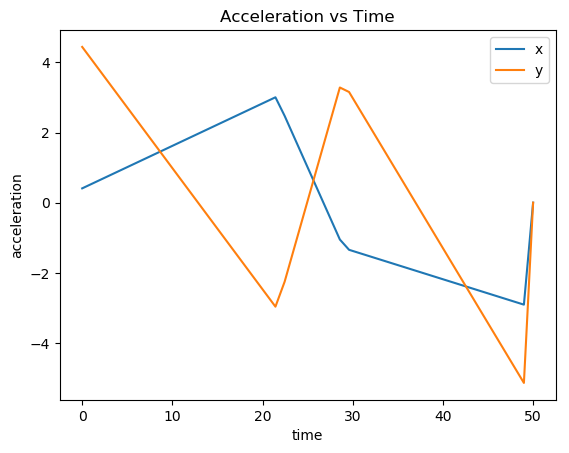

In [14]:
# Acceleration plot
x = range(0, stop=time, length=time)
plot(x[:], getvalue(u_A)[1,:], label="x" )
plot(x[:], getvalue(u_A)[2,:], label="y" )
title("Acceleration vs Time")
xlabel("time")
ylabel("acceleration")
legend()
;